In [1]:
import json

import pandas as pd
import numpy as np
import networkx as nx

from tqdm import tqdm

In [2]:
import cPickle

In [21]:
from IPython.display import display

from matplotlib import image
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

In [4]:
!ls ../data

facts.json  titles.csv	train.csv  urls.csv


In [5]:
!wc -l ../data/*.csv

   1796480 ../data/titles.csv
    506136 ../data/train.csv
  14148535 ../data/urls.csv
  16451151 total


In [6]:
!wc -l ../submission.txt

215307 ../submission.txt


In [7]:
!head ../data/train.csv

0b2e6f4410f4d6e2a42b856138f3d1a5,70ca9529383994367b1b1cccd396181b
0b2e6f4410f4d6e2a42b856138f3d1a5,7d40857ed797cddfbf657082bf31dafa
70ca9529383994367b1b1cccd396181b,7d40857ed797cddfbf657082bf31dafa
6887d079ef94f1331eea6f407921a99c,b4960892c01a77c4fd78e9c462684093
a83d7b0f16e3c47f5f30e9887ddfbf9c,b4960892c01a77c4fd78e9c462684093
6887d079ef94f1331eea6f407921a99c,a83d7b0f16e3c47f5f30e9887ddfbf9c
858df101e14cc57bd325c3c5be64430d,fa40b234a1848bedc21e056b51184524
1365f7a10108ac03984c905e2b9931d7,858df101e14cc57bd325c3c5be64430d
858df101e14cc57bd325c3c5be64430d,ba5e426a721e78edc59884879018cd71
858df101e14cc57bd325c3c5be64430d,cd3866219da0ccfe5d75b9f678f94039


In [5]:
df_train = pd.read_csv('../data/train.csv', header=None)
df_train.columns = ['user_1', 'user_2']
df_train.head()

,user_1,user_2
0,0b2e6f4410f4d6e2a42b856138f3d1a5,70ca9529383994367b1b1cccd396181b
1,0b2e6f4410f4d6e2a42b856138f3d1a5,7d40857ed797cddfbf657082bf31dafa
2,70ca9529383994367b1b1cccd396181b,7d40857ed797cddfbf657082bf31dafa
3,6887d079ef94f1331eea6f407921a99c,b4960892c01a77c4fd78e9c462684093
4,a83d7b0f16e3c47f5f30e9887ddfbf9c,b4960892c01a77c4fd78e9c462684093


In [34]:
train_users = set(df_train.user_1) | set(df_train.user_2)
len(train_users), len(df_train)

(240732, 506136)

In [7]:
users12 = set(df_train.user_1 + '_' + df_train.user_2)
users21 = set(df_train.user_2 + '_' + df_train.user_1)
len(users12 & users21)

0

In [8]:
G = nx.Graph()

for u1, u2 in tqdm(zip(df_train.user_1, df_train.user_2)):
    G.add_edge(u1, u2)

In [9]:
nx.number_connected_components(G)

60001

In [10]:
components = nx.connected_components(G)
sizes = [len(c) for c in components]
pd.Series(sizes).describe()

count    60001.000000
mean         4.012133
std          2.187674
min          2.000000
25%          3.000000
50%          3.000000
75%          4.000000
max         52.000000
dtype: float64

In [11]:
from itertools import combinations

In [14]:
components = nx.connected_components(G)
total_possible_num = 0
for component in tqdm(components):
    no_comb = len(list(combinations(component, 2)))
    total_possible_num = total_possible_num + no_comb

In [15]:
total_possible_num - len(df_train)

0

In [16]:
components = nx.connected_components(G)
comp_to_idx = {}
for idx, component in enumerate(components):
    for node in component:
        comp_to_idx[node] = idx

In [17]:
(df_train.user_1.apply(comp_to_idx.get) == df_train.user_2.apply(comp_to_idx.get)).all()

True

In [18]:
df_train['component'] = df_train.user_1.apply(comp_to_idx.get)
df_train.head()

,user_1,user_2,component
0,0b2e6f4410f4d6e2a42b856138f3d1a5,70ca9529383994367b1b1cccd396181b,750
1,0b2e6f4410f4d6e2a42b856138f3d1a5,7d40857ed797cddfbf657082bf31dafa,750
2,70ca9529383994367b1b1cccd396181b,7d40857ed797cddfbf657082bf31dafa,750
3,6887d079ef94f1331eea6f407921a99c,b4960892c01a77c4fd78e9c462684093,30046
4,a83d7b0f16e3c47f5f30e9887ddfbf9c,b4960892c01a77c4fd78e9c462684093,30046


In [56]:
with open('tmp/df_train.bin', 'wb') as f:
    cPickle.dump(df_train, f)

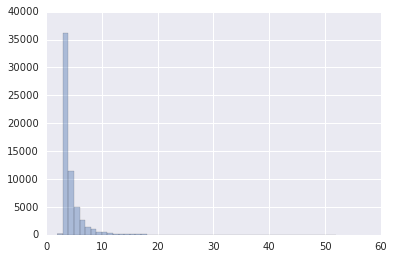

In [24]:
sns.distplot(sizes, kde=False)

In [8]:
!head ../data/urls.csv

9140201,ed95a9a5be30e4c8/5162fc6a223f248d/31a42ef13edf7d8a/c2ee3aa455c8b288/656e9a1b3fa15996
6684120,ed95a9a5be30e4c8/5162fc6a223f248d/31a42ef13edf7d8a/c2ee3aa455c8b288/239a176e400bb8a1
9004649,ed95a9a5be30e4c8/5162fc6a223f248d/31a42ef13edf7d8a/c2ee3aa455c8b288/5ae9335ee8b434ce
1414226,ed95a9a5be30e4c8/5162fc6a223f248d/31a42ef13edf7d8a/3c2f1eeb42adc015
4225543,ed95a9a5be30e4c8/5162fc6a223f248d/9445309bd4b645/2a3448823137f338/06429febabd51328
8141140,ed95a9a5be30e4c8/5162fc6a223f248d/9445309bd4b645/e05694da05942df
13697961,ed95a9a5be30e4c8/5162fc6a223f248d/9445309bd4b645/1f136441c8ab7767
11292447,ed95a9a5be30e4c8/5162fc6a223f248d/9445309bd4b645/f0c1b1b0072784c5
12853589,93bbf66ff7f27f7f/9bed6b58ceea060/a57865e4b9a99b16?083793a328d707c
2611126,93bbf66ff7f27f7f/1a28b3a2ab7e0cbd


In [9]:
!head ../data/titles.csv

5111291,3a53d906e833c763 473ccdaadb0a594 6141ef2792b67c64 6437137c27f55d27
6847456,e89c7e0a7501863e e16ec727e36197f3 b764c27d3881dc01 003936c4683cbc1d a37475fd0852f506 e89c7e0a7501863e
10165396,71947691380e18 c3c6f5010c72e19b 3ca11329476af2fb b764c27d3881dc01 003936c4683cbc1d
2645961,fe6111a712dba15 3ca11329476af2fb b764c27d3881dc01 003936c4683cbc1d
11573898,58e99c0c86108d21 e8110332551066ff 67a7830fc356f508
9136686,13a5920765ae0a2f
6246913,686e721ec02232bd 52b9374f260d951f ec1c23c9c0769786 2d5c925544bf413f 67a7830fc356f508
11702872,686e721ec02232bd 672bada065956915 2d5c925544bf413f 67a7830fc356f508
9536255,2857599a49a30ac6 4ad303956a23cc44 531b29ff0a63902a 2c26d34deaade313 91b05a31959e0573 26727c92e7b07143 abb74e1f1de36d3 37a20a398fae482a
7449504,cd8ba74c635ea8bf 1b71d5e5322d53ec eb68ebeae21f70c3 b8c6a4cd279bc49 7af36d250bc7134 cb6df886a95bdd67 7af36d250bc7134


In [26]:
!head -n 1 ../data/facts.json

{"facts": [{"fid": 9140201, "ts": 1464769462076}, {"fid": 9140201, "ts": 1464769312076}, {"fid": 9140201, "ts": 1464769282076}, {"fid": 6684120, "ts": 1464769248691}, {"fid": 6684120, "ts": 1464769068691}, {"fid": 9004649, "ts": 1464768967747}, {"fid": 1414226, "ts": 1464768953582}, {"fid": 9004649, "ts": 1464768907747}, {"fid": 9004649, "ts": 1464768787747}, {"fid": 4225543, "ts": 1464764699151}, {"fid": 4225543, "ts": 1464764639151}, {"fid": 8141140, "ts": 1464764633759}, {"fid": 4225543, "ts": 1464764609151}, {"fid": 4225543, "ts": 1464764519151}, {"fid": 13697961, "ts": 1464764384950}, {"fid": 4225543, "ts": 1464764339151}, {"fid": 4225543, "ts": 1464764279151}, {"fid": 4225543, "ts": 1464764099151}, {"fid": 11292447, "ts": 1464764030849}, {"fid": 4225543, "ts": 1464763979151}, {"fid": 4225543, "ts": 1464762899151}, {"fid": 4225543, "ts": 1464762779151}, {"fid": 4225543, "ts": 1464762719151}, {"fid": 4225543, "ts": 1464762599151}, {"fid": 4225543, "ts": 1464762569151}, {"fid": 4225

In [47]:
from collections import defaultdict, Counter

In [28]:
facts_to_users = defaultdict(list)
users_to_facts = {}

with open('../data/facts.json', 'r') as fact_file:
    for line in tqdm(fact_file):
        d = json.loads(line)
        uid = d['uid']
        fids = [f['fid'] for f in d['facts']]
        for fid in fids:
            facts_to_users[fid].append(uid)
        users_to_facts[uid] = fids

In [35]:
users = set(users_to_facts.keys())
test_users = users - train_users
len(train_users), len(test_users)

(240732, 98673)

In [57]:
with open('tmp/test-train-users.bin', 'wb') as f:
    cPickle.dump((train_users, test_users), f)

In [36]:
len(facts_to_users.keys())

14148535

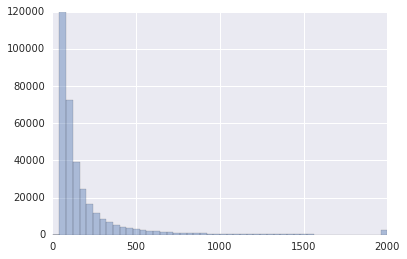

count    339405.000000
mean        196.840029
std         269.514074
min           2.000000
25%          70.000000
50%         106.000000
75%         199.000000
max        2000.000000
dtype: float64

In [43]:
facts_sizes = [len(f) for f in users_to_facts.values()]
sns.distplot(facts_sizes, kde=False)
plt.show()
pd.Series(facts_sizes).describe()

In [46]:
user_sizes = [len(u) for u in facts_to_users.values()]
pd.Series(user_sizes).describe()

count    14148535.000000
mean            4.721937
std           377.965495
min             1.000000
25%             1.000000
50%             1.000000
75%             2.000000
max        875356.000000
dtype: float64

In [49]:
cnt = Counter({u: len(v) for (u, v) in facts_to_users.items() if len(v) > 1})
most_common_facts = cnt.most_common(20)
most_common_facts

[(2694972, 875356),
 (8799201, 475277),
 (4155546, 285375),
 (8849469, 255884),
 (10589587, 244506),
 (8540688, 243527),
 (11433197, 233564),
 (5743549, 225490),
 (7608004, 217233),
 (10577741, 198511),
 (5313723, 195309),
 (14046140, 180373),
 (2102032, 169105),
 (10086853, 154529),
 (12926861, 148107),
 (10782343, 138411),
 (7095228, 134720),
 (4840746, 128802),
 (12746145, 122239),
 (116415, 120533)]

In [52]:
np.mean([len(v) == 1 for v in facts_to_users.values()])

0.62078130350598137

In [53]:
np.mean([len(v) <= 2 for v in facts_to_users.values()])

0.80189779365849534

In [54]:
np.mean([len(v) <= 5 for v in facts_to_users.values()])

0.9217465271139379

## Some data preprocessing

In [35]:
cnt = 0
code_dict = {}

def encode(token):
    if token is None:
        return None

    if token in code_dict:
        code = code_dict[token]
        return np.base_repr(code, base=36)

    global cnt
    code = cnt
    code_dict[token] = code
    cnt = cnt + 1
    return np.base_repr(code, base=36)

In [36]:
titles = {}

with open('../data/titles.csv', 'r') as f:
    for line in tqdm(f):
        uid, title = line.strip().split(',')
        tokens = title.split(' ')
        code_tokens = [encode(t) for t in tokens]
    
        titles[int(uid)] = ' '.join(code_tokens)

In [37]:
cnt

305261

In [39]:
len(titles)

1796480

In [41]:
url_dicts = []

with open('../data/urls.csv', 'r') as f:
    for line in tqdm(f):
        url_id, url = line.strip().split(',')
        url_id = int(url_id)

        param = None
        if '?' in url:
            url, param = url.split('?')

        url_tokens = url.split('/')
        url_tokens_code = [encode(t) for t in url_tokens]

        param = encode(param)
        domain = url_tokens_code[0]
        address = url_tokens_code[1:]

        row_dict = {'url_id': url_id, 'domain': domain, 
                    'address': ' '.join(address), 'param': param,
                    'title': titles.get(url_id, '') }
        url_dicts.append(row_dict)

In [42]:
cnt

12889026

In [43]:
url_dicts[:5]

[{'address': 'UZ9 4FRS 6JJI 6JJJ',
  'domain': '6JJH',
  'param': None,
  'title': 'ES ET EU EV BW T',
  'url_id': 9140201},
 {'address': 'UZ9 4FRS 6JJI 6JJK',
  'domain': '6JJH',
  'param': None,
  'title': 'ES ET EU EV BW T',
  'url_id': 6684120},
 {'address': 'UZ9 4FRS 6JJI 6JJL',
  'domain': '6JJH',
  'param': None,
  'title': 'ES ET EU EV BW T',
  'url_id': 9004649},
 {'address': 'UZ9 4FRS 6JJM',
  'domain': '6JJH',
  'param': None,
  'title': '',
  'url_id': 1414226},
 {'address': 'UZ9 5QDM 1RIQ 6JJN',
  'domain': '6JJH',
  'param': None,
  'title': 'M 2T 2P 2R BW T',
  'url_id': 4225543}]

In [44]:
with open('tmp/url_dict.bin', 'wb') as f:
    cPickle.dump(url_dicts, f)

In [55]:
with open('tmp/url_dict.bin', 'rb') as f:
    url_dicts = cPickle.load(f)

In [95]:
df_urls = pd.DataFrame(url_dicts, columns=['url_id', 'domain', 'address', 'param', 'title'])
df_urls.set_index('url_id', inplace=1)
df_urls.param.fillna('', inplace=1)
df_urls.head()

,domain,address,param,title
url_id,,,,
9140201,6JJH,UZ9 4FRS 6JJI 6JJJ,,ES ET EU EV BW T
6684120,6JJH,UZ9 4FRS 6JJI 6JJK,,ES ET EU EV BW T
9004649,6JJH,UZ9 4FRS 6JJI 6JJL,,ES ET EU EV BW T
1414226,6JJH,UZ9 4FRS 6JJM,,
4225543,6JJH,UZ9 5QDM 1RIQ 6JJN,,M 2T 2P 2R BW T


In [96]:
with open('tmp/df_url.bin', 'wb') as f:
    cPickle.dump(df_urls, f)

In [97]:
top = df_urls.loc[[f for (f, _) in most_common_facts]]

In [98]:
domain_to_uid = dict(zip(df_urls.domain, df_urls.index))

In [99]:
len(df_urls)

14148535

In [100]:
len(domain_to_uid), 1.0 * len(domain_to_uid) / len(df_urls)

(230297, 0.016277091585807296)

In [101]:
no_param = df_urls.domain + ' ' + df_urls.address
1.0 * (no_param).nunique() / len(df_urls)

0.637780165932374

In [102]:
df_titles = df_urls.title[df_urls.title != '']

In [103]:
len(df_titles), 1.0 * df_titles.nunique() / len(df_titles)

(1796480, 0.6900839419308871)

In [104]:
np.random.seed(1)
random_users = list(np.random.choice(users_to_facts.keys(), size=5))
random_users 

[u'4510c33098f774ef91efd1933568db58',
 u'cc85d0192f425c7053961e41009ddfbf',
 u'99819f8a6f8e4030bc0a8ca82c00d894',
 u'6a54cf3460640e31e869c351f71a9a33',
 u'1f944a2379de11338a2f65ce1aaf106b']

In [105]:
for uid in random_users:
    print 'user %s' % uid
    facts = users_to_facts[uid]
    df_facts = df_urls.iloc[facts]
    display(df_facts.head(n=3))
    print '%d rows' % len(df_facts)
    
    print 

user 4510c33098f774ef91efd1933568db58


,domain,address,param,title
url_id,,,,
2424896,UJQ7,2FO UJQ8 6JLX 6PN6,,
513749,6RCK,6RCL HUW 6YH0W,,O 436 AY 4E0 2S M 436 AT
629520,EIMM,MI G1I 4SR 6KMH,,


52 rows

user cc85d0192f425c7053961e41009ddfbf


,domain,address,param,title
url_id,,,,
3900430,6KZ4,6JVH,4M57Z,
558640,78RF,6N6X 2C4C TZTX QPIY,,
3837463,ASR8,KDAR,,


67 rows

user 99819f8a6f8e4030bc0a8ca82c00d894


,domain,address,param,title
url_id,,,,
13626566,9KTB,9KTC UGZ 51F7N,,
13220193,7JGS,6RCL HUW 4NZ1Y,,
13626566,9KTB,9KTC UGZ 51F7N,,


62 rows

user 6a54cf3460640e31e869c351f71a9a33


,domain,address,param,title
url_id,,,,
2725406,6JJH,6UR4 6KQF 5TZCQ,,
14083298,1HSG6,,72GUL,
2725406,6JJH,6UR4 6KQF 5TZCQ,,


637 rows

user 1f944a2379de11338a2f65ce1aaf106b


,domain,address,param,title
url_id,,,,
2896342,6KFL,6PRXU,,
4032184,6KBO,6KBP,2PCI1,
1205258,6JJH,6QNO 6KZU 4WZ6P,,


500 rows



Now can try to put this to ES for every user

In [457]:
indexes = {fid: i for (i, fid) in enumerate(df_urls.index)}

In [443]:
from elasticsearch import Elasticsearch
es = Elasticsearch(host='172.17.0.2')
# es.indices.delete(index='user')

{u'acknowledged': True}

In [460]:
from elasticsearch_dsl.connections import connections
from elasticsearch_dsl import Mapping, String, Nested
from elasticsearch_dsl import analyzer, tokenizer

whitespace_analyzer = analyzer('whitespace_analyzer', tokenizer=tokenizer('whitespace'))
con = connections.create_connection(host='172.17.0.2')

In [461]:
mapping = Mapping('user_log')

fact = Nested(multi=True, include_in_parent=True)
fact.field('domain', String(analyzer=whitespace_analyzer))
fact.field('address', String(analyzer=whitespace_analyzer))
fact.field('param', String(analyzer=whitespace_analyzer))
fact.field('title', String(analyzer=whitespace_analyzer))

mapping.field('fact', fact)
mapping.save('user')

d = mapping.to_dict()
print json.dumps(d, indent=2)

{
  "user_log": {
    "properties": {
      "fact": {
        "type": "nested", 
        "include_in_parent": true, 
        "properties": {
          "domain": {
            "type": "string", 
            "analyzer": "whitespace_analyzer"
          }, 
          "address": {
            "type": "string", 
            "analyzer": "whitespace_analyzer"
          }, 
          "param": {
            "type": "string", 
            "analyzer": "whitespace_analyzer"
          }, 
          "title": {
            "type": "string", 
            "analyzer": "whitespace_analyzer"
          }
        }
      }
    }
  }
}


In [462]:
query = {'match_all': {}}
body = {'query': query, 'fields': ['_id']}
res = es.search(index='user', doc_type='user_log', body=body)
res['hits']['hits']

[]

In [463]:
def chunk(lst, n):
    result = []
    for i in range(0, len(lst), n):
        result.append(lst[i:i+n])
    return result
chunk(range(10), 3)

[[0, 1, 2], [3, 4, 5], [6, 7, 8], [9]]

In [464]:
from elasticsearch import helpers

In [465]:
for batch in tqdm(chunk(users_to_facts.items(), 100)):
    actions = []
    for uid, facts in batch:
        idx = [indexes[f] for f in facts]
        facts = df_urls.iloc[idx]
        user = {'fact': facts.to_dict(orient='records')}
        actions.append({'_id': uid, '_index': 'user', '_type': 'user_log', '_source': user})

    helpers.bulk(es, actions)

In [468]:
query = {'match_all': {}}
body = {'query': query, 'fields': ['_id']}
res = es.search(index='user', doc_type='user_log', body=body)
res['hits']['total'], len(users_to_facts)

(339405, 339405)

In [469]:
uid = random_users[0]

In [470]:
def most_similar(uid):
    facts = users_to_facts[uid]
    idx = [indexes[f] for f in facts]
    facts = df_urls.iloc[idx]

    all_tokens = facts.to_string(header=False, index=False)
    all_tokens = [t for t in re.split('\s+', all_tokens) if t]

    query = {
        'query': {
            'multi_match': {
                'query': ' '.join(all_tokens),
                'type': 'cross_fields',
                'fields': ['fact.domain^3', 'fact.address', 'fact.param', 'fact.title^2'],
                'analyzer': 'whitespace_analyzer',
                #'tie_breaker': 1.0,
                #'minimum_should_match': '5%',
            }
        },
        'fields': ['_id']
    }

    res = es.search(index='user', doc_type='user_log', body=query)
    hits = res['hits']['hits']
    return [(d['_id'], d['_score']) for d in hits if d['_id'] != uid]

In [473]:
print uid

most_similar(uid)

90e6fdca0b3bdfdbd3298f982f9a6892


[(u'c041d4be84cec4ce764aaf8b71ee938d', 2.495066),
 (u'1c65f040ef0a224ed16d1a249996c8d2', 1.9890103),
 (u'6149cafee3f6c607ac5c792de49f6435', 1.9748555),
 (u'd4f7a36889720ce934f5e6216b57265c', 1.8945218),
 (u'da250a83222684be18221e153e561e85', 1.8142211),
 (u'7f24cb4fc5bd5aa0f145acb65fdb3c68', 1.7913772),
 (u'defc68230bd4a72fa1e2ec1fa35ea823', 1.7673705),
 (u'bd737c7c57ff8abf3693ae411e914004', 1.7507018),
 (u'6eb76cb9e2f86d12d7ac07aff904455b', 1.6934497)]

In [488]:
components = nx.connected_components(G)
node_to_others = {}
for component in tqdm(components):
    for node in component:
        node_to_others[node] = component - {node}

node_to_others[uid]

{'001f0458e8591f4a74535f56dd626e51',
 '138696494bf8120e0aac853fd49f8b19',
 '7d144a1ba9f8e90b702de4008a7892ab',
 '83adc1accdf8e4efb8c8b99cffa44969',
 'a4f0652b9962f24185dcf05a4bbe5030',
 'b2f2f9d6198b4a3074d90b2b606211a9'}

In [502]:
random_users = set(np.random.choice(list(train_users), size=500))

In [513]:
def find_similar(uid):
    query = {
        'query': {
            'more_like_this': {
                'like': {
                    '_index': 'user',
                    '_type': 'user_log',
                    '_id': uid,
                },
                'fields': ['fact.domain^2', 'fact.address', 'fact.param', 'fact.title'],
            }
        },
        'fields': ['_id']
    }

    res = es.search(index='user', doc_type='user_log', body=query)
    hits = res['hits']['hits']
    return [(d['_id'], d['_score']) for d in hits]

In [514]:
retrieved = 0
relevant = 0

for uid in tqdm(random_users):
    similar = find_similar(uid)
    others_found = {u for (u, _) in similar}
    others_truth = node_to_others[uid]
    retrieved = retrieved + len(others_found & others_truth) 
    relevant = relevant + len(others_truth)

retrieved, relevant

(764, 2003)

## Lets create some BOW stuff

In [6]:
all_titles = [d['title'] for d in url_dicts if d['title']]

In [9]:
from utils import split

In [9]:
titles_tfidf = TfidfVectorizer(analyzer=split, min_df=20, dtype=np.float32)
matrix_titles = titles_tfidf.fit_transform(all_titles)
matrix_titles.shape

(1796480, 32197)

In [10]:
with open('tmp/titles_tfidf.bin', 'wb') as f:
    cPickle.dump(titles_tfidf, f)

In [11]:
titles_svd = TruncatedSVD(n_components=100, random_state=1)
titles_svd.fit(matrix_titles)

TruncatedSVD(algorithm='randomized', n_components=100, n_iter=5,
       random_state=1, tol=0.0)

In [14]:
X = all_titles[:4] + ['']
X

['ES ET EU EV BW T',
 'ES ET EU EV BW T',
 'ES ET EU EV BW T',
 'M 2T 2P 2R BW T',
 '']

In [15]:
from sklearn.preprocessing import normalize

In [16]:
X = titles_tfidf.transform(X)
X.dot(X.T).toarray()

array([[ 1.        ,  1.        ,  1.        ,  0.14265732,  0.        ],
       [ 1.        ,  1.        ,  1.        ,  0.14265732,  0.        ],
       [ 1.        ,  1.        ,  1.        ,  0.14265732,  0.        ],
       [ 0.14265732,  0.14265732,  0.14265732,  1.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ]])

In [17]:
X = titles_svd.transform(X)
X = normalize(X)
X.dot(X.T)

array([[ 1.        ,  1.        ,  1.        ,  0.39588769,  0.        ],
       [ 1.        ,  1.        ,  1.        ,  0.39588769,  0.        ],
       [ 1.        ,  1.        ,  1.        ,  0.39588769,  0.        ],
       [ 0.39588769,  0.39588769,  0.39588769,  1.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ]])

In [18]:
with open('tmp/titles_svd.bin', 'wb') as f:
    cPickle.dump(titles_svd, f)

In [19]:
del X, matrix_titles, titles_svd, titles_tfidf

In [6]:
all_urls = [d['domain'] + ' ' + d['address'] for d in url_dicts]

In [7]:
del url_dicts

In [10]:
urls_tfidf = TfidfVectorizer(analyzer=split, min_df=20, dtype=np.float32)
matrix_urls = urls_tfidf.fit_transform(all_urls)
matrix_urls.shape

(14148535, 68174)

In [11]:
with open('tmp/urls_tfidf.bin', 'wb') as f:
    cPickle.dump(urls_tfidf, f)

In [12]:
del all_urls, urls_tfidf

In [13]:
total_size = matrix_urls.shape[0]
idx = np.arange(total_size, dtype=np.int32)
np.random.seed(10)
sample_idx = np.random.choice(idx, size=int(total_size * 0.5), replace=False)
del idx

In [14]:
matrix_urls = matrix_urls[sample_idx].copy()

In [15]:
urls_svd = TruncatedSVD(n_components=150, random_state=1)
urls_svd.fit(matrix_urls)

TruncatedSVD(algorithm='randomized', n_components=150, n_iter=5,
       random_state=1, tol=0.0)

In [16]:
with open('tmp/urls_svd.bin', 'wb') as f:
    cPickle.dump(urls_svd, f)

## BoW for users